## Sentiment analysis on twitter 2020 election data

The 2020 US election is happening on the 3rd November 2020, today as of writing this kernel, and the resulting impact to the world will no doubt be large, irrespective of which candidate is elected! After reading the two papers, [here](https://arxiv.org/abs/1706.02271) and [here](https://dl.acm.org/doi/fullHtml/10.1145/3339909), I was inspired to attempt a similar sentiment analysis myself!

However before I could do this I had to create a [dataset](https://www.kaggle.com/manchunhui/us-election-2020-tweets) first! Please feel free to download and use at your pleasure, the intention is to obtain data upto the end of the 4th of Nov. With regards to the dataset, ot contains two .csv files containing tweets obtained using snsscrape, keywords #JoeBiden, #DonaldTrump, ,#Biden #Trump with the Twitter API.


## Chapter 1: Exploratory Data Analysis
Before we jump into the sentiment analysis, lets carry some exploration of the dataset! You can view preliminary EDA at this [link](https://www.kaggle.com/manchunhui/starter-kernel-us-election-2020-tweets-prelim-eda), I will not be running over the same details in here. I've decided to hide some of the visualisation code as it distracts from the flow of the analysis, please click on the buttons to view the code if you wish.

In [1]:
!pip install langdetect

     |████████████████████████████████| 981 kB 2.8 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-py3-none-any.whl size=993191 sha256=fe0d018ad133186ec138af9f676486af809121db877b3f32c65e085fef9c4fcb
  Stored in directory: /root/.cache/pip/wheels/59/f6/9d/85068904dba861c0b9af74e286265a08da438748ee5ae56067
Successfully built langdetect


In [2]:
# Import Libraries
import os
import time
import missingno as msno
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk, re, string, collections, unicodedata

%matplotlib inline
from matplotlib import cm, dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from datetime import datetime, timedelta
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from langdetect import detect
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/us-election-2020-tweets/hashtag_joebiden.csv
/kaggle/input/us-election-2020-tweets/hashtag_donaldtrump.csv


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
# Reading both the csv files
tweets_biden = pd.read_csv('/kaggle/input/us-election-2020-tweets/hashtag_joebiden.csv', lineterminator='\n', parse_dates=True)
tweets_trump = pd.read_csv('/kaggle/input/us-election-2020-tweets/hashtag_donaldtrump.csv', lineterminator='\n', parse_dates=True)

# Clean data
tweets_biden['country'].replace({'United States':'United States of America'}, inplace=True)
tweets_trump['country'].replace({'United States':'United States of America'}, inplace=True)


# Add Features
def normalise(x,y):
    x = np.array(x)
    y = np.array(y)
    return np.where(x == 0, 0, x / y)

def sentiment(data):
    temp=[]
    for row in data:
        tmp=sid.polarity_scores(row)
        temp.append(tmp)
    return temp

# convert to datetime object
tweets_biden['user_join_date']=pd.to_datetime(tweets_biden['user_join_date'])
tweets_trump['user_join_date']=pd.to_datetime(tweets_trump['user_join_date'])
tweets_biden['collected_at']=pd.to_datetime(tweets_biden['collected_at'])
tweets_trump['collected_at']=pd.to_datetime(tweets_trump['collected_at'])
tweets_biden['created_at']=pd.to_datetime(tweets_biden['created_at'])
tweets_trump['created_at']=pd.to_datetime(tweets_trump['created_at'])

# create additional date time columns
tweets_biden['created_at_r']=tweets_biden['created_at'].dt.strftime('%Y-%m-%d %H')
tweets_trump['created_at_r']=tweets_trump['created_at'].dt.strftime('%Y-%m-%d %H')
tweets_biden['created_at_r2']=tweets_biden['created_at'].dt.strftime('%m-%d')
tweets_trump['created_at_r2']=tweets_trump['created_at'].dt.strftime('%m-%d')

# normalise likes and retweets to allow fair analysis
b_tdiff=(tweets_biden['collected_at'] - tweets_biden['created_at'])
t_tdiff=(tweets_trump['collected_at'] - tweets_trump['created_at'])
b_tdiff=(b_tdiff.dt.days * 24 + b_tdiff.dt.seconds / 3600)
t_tdiff=(t_tdiff.dt.days * 24 + t_tdiff.dt.seconds / 3600)

# Use numpy vectorisation to create new columns for normalised likes and retweets
tweets_biden['likes_norm'] = normalise(tweets_biden['likes'],b_tdiff)
tweets_biden['retweet_norm'] = normalise(tweets_biden['retweet_count'],b_tdiff)
tweets_trump['likes_norm'] = normalise(tweets_trump['likes'],t_tdiff)
tweets_trump['retweet_norm'] = normalise(tweets_trump['retweet_count'],t_tdiff)

In [4]:
# Visualisation args
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']
barstyle = {"edgecolor":"black", "linewidth":1}
heatmap1_args = dict(annot=True, fmt='.0f', square=False, cmap=cm.get_cmap("RdGy", 10), center = 90, vmin=0, vmax=10000, lw=4, cbar=False)
heatmap2_args = dict(annot=True, fmt='.3f', square=False, cmap="Greens", center = 0.5, lw=4, cbar=False)
heatmap3_args = dict(annot=True, fmt='.0f', square=False, cmap=cmap, center = 9200, lw=4, cbar=False)

def hide_axes(this_ax):
    this_ax.set_frame_on(False)
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    return this_ax

def draw_heatmap1(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap1_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap2(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap2_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap3(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap3_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def thousands1(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)

formatterK1 = FuncFormatter(thousands1)

def thousands2(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)

formatterK2 = FuncFormatter(thousands2)

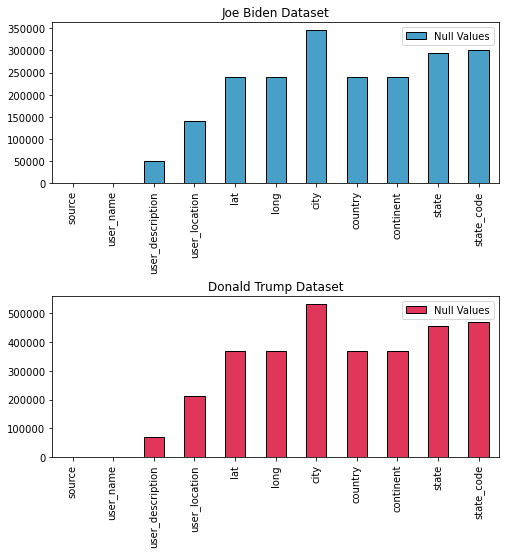

In [5]:
na_vals_b=pd.DataFrame({'Null Values':tweets_biden.isna().sum()})
na_vals_b=na_vals_b.loc[na_vals_b['Null Values'] > 0]
na_vals_t=pd.DataFrame({'Null Values':tweets_trump.isna().sum()})
na_vals_t=na_vals_t.loc[na_vals_t['Null Values'] > 0]

# Null values visualisation for tweets about Joe Biden and Donald Trump
fig, ax=plt.subplots(2,1, figsize=(8,8), gridspec_kw={'hspace':0.7})

na_vals_b.plot.bar(color=barcolors[3], **barstyle, ax=ax[0])
ax[0].set_title('Joe Biden Dataset')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

na_vals_t.plot.bar(color=barcolors[6], **barstyle, ax=ax[1])
ax[1].set_title('Donald Trump Dataset')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
plt.show()

Geo spatial features ***```lat, long, city, country, continent, state state code```*** were all derived from ***```user_location```***, using ***sciSpacy NER*** and ***OpenCage API***. It should be noted due a number of factors (such as erroneous ***```user_location```*** inputs, my methods of deriving useful data from subject erroneous inputs and its impact on ***OpenCage API*** returned results), the geo spatial features should be used with caution! 

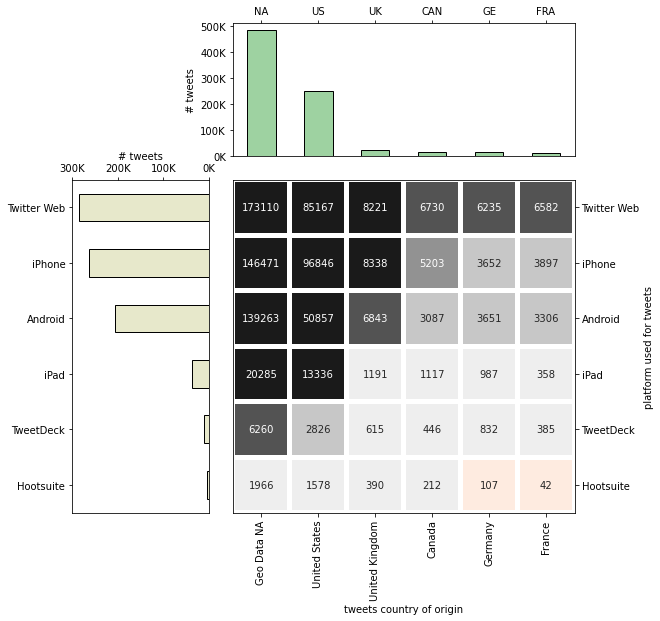

In [6]:
source_df=pd.concat([tweets_biden[['source','tweet','country']].copy(),tweets_trump[['source','tweet','country']].copy()])
source_df['country'].replace({'United States of America':'United States'}, inplace=True)
source_df=source_df.fillna('Geo Data NA')
source_df=source_df.drop_duplicates()

sources=pd.DataFrame(source_df.groupby(['source'])['tweet'].count().sort_values(ascending=False)[:6])
sources=sources.reset_index()
sourceslst=sources.source.to_list()

country=pd.DataFrame(source_df.groupby(['country'])['tweet'].count().sort_values(ascending=False)[:6])
country=country.reset_index()
countrylst=country.country.to_list()

platXtab=pd.DataFrame(source_df.groupby(['source','country'])['tweet'].count().unstack().fillna(0))

fig, ax=plt.subplots(2,2, figsize=(9,9), 
                     gridspec_kw={'height_ratios':[2,5], 'width_ratios':[2,5], 'wspace':0.1, 'hspace':0.1})

hide_ax = ax[0,0]
hide_axes(hide_ax)

hm_ax = ax[1,1]
draw_heatmap1(platXtab.loc[sourceslst,countrylst], hm_ax)
hm_ax.set_xlabel('tweets country of origin')
hm_ax.set_ylabel('platform used for tweets')
hm_ax.set_yticklabels(('Twitter Web','iPhone','Android','iPad','TweetDeck','Hootsuite'), rotation=0) 

bar_ax = ax[0,1]
platXtab.loc[sourceslst,countrylst].sum().plot.bar(ax=bar_ax, color=barcolors[1],**barstyle)
bar_ax.set_xlabel(bar_ax.get_xlabel())
bar_ax.xaxis.tick_top()
bar_ax.xaxis.set_label_position("top")
bar_ax.yaxis.set_major_formatter(formatterK1)
bar_ax.set_xticklabels(('NA', 'US', 'UK', 'CAN', 'GE','FRA'), rotation=0) 
bar_ax.set_xlabel('')
bar_ax.set_ylabel('# tweets')

barh_ax = ax[1,0]
platXtab.loc[sourceslst,countrylst].sum(axis=1)[::-1].plot.barh(ax=barh_ax, color=barcolors[2],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.xaxis.set_major_formatter(formatterK1)
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_yticklabels(('Hootsuite','TweetDeck','iPad','Android','iPhone','Twitter Web'), rotation=0) 
barh_ax.set_xlabel('# tweets')
barh_ax.set_ylabel('')
plt.show()

First of all I must acknowledge that I unashamedly borrowed this heatmap design from @tkubacka, shown in her excellent [kernel](https://www.kaggle.com/tkubacka/a-story-told-through-a-heatmap), as it great at displaying a lot of information in compact space!

From the above heatmap we can see that most tweets, in the two .csv files, are published from ***```Twitter Web, Twitter iPhone, Twitter Android or Twitter iPad```*** with most of these from the US or an unidentified location.

In [7]:
world=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
from shapely.geometry import Point, Polygon
crs = {'init': 'EPSG:4326'}

tmp=pd.concat([tweets_biden[['lat','long']].copy(),tweets_trump[['lat','long']].copy()])
tmp=tmp.dropna()
geometry = [Point(xy) for xy in zip(tmp['long'],tmp['lat'])]
geo_df=gpd.GeoDataFrame(tmp, crs=crs, geometry = geometry)

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


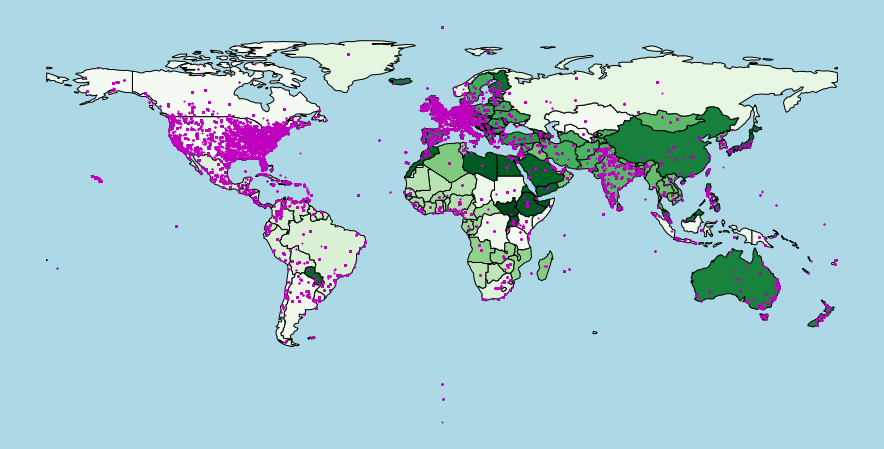

In [8]:
fig, ax = plt.subplots(1,figsize=(16,8), facecolor='lightblue')
world = world[world.name != "Antarctica"]
world.plot(ax=ax, cmap='Greens', edgecolors='black')
geo_df.plot(ax=ax, markersize=1, color='m', marker='o')
ax.axis('off')
plt.show()

Plotting all the available geo data shows that many countries around the world are tweeting about the two presidential candidates.

In [9]:
%%time
def detect_tweetlang(tweet):
    try:
        return detect(tweet)
    except:
        return 'unknown'

# Combine two data files and drop duplicates
lang_df=pd.concat([tweets_biden[['tweet','country']].copy(),tweets_trump[['tweet','country']].copy()])
lang_df['country'].replace({'United States of America':'United States'}, inplace=True)
lang_df=lang_df.fillna('Geo Data NA')
lang_df=lang_df.drop_duplicates()

# Randomly sample data for langauge analysis
lang_smdf=lang_df.sample(n=4000).copy()
lang_smdf['lang'] = lang_smdf['tweet'].apply(detect_tweetlang)

# Select top five languages and five countries for heatmap
langs=pd.DataFrame(lang_smdf.groupby(['lang'])['tweet'].count().sort_values(ascending=False)[:5])
langs=langs.reset_index()
langslst=langs.lang.to_list()

country=pd.DataFrame(lang_smdf.groupby(['country'])['tweet'].count().sort_values(ascending=False)[:5])
country=country.reset_index()
countrylst=country.country.to_list()

# Create a crosstab to feed data to heatmap
langXtab=pd.crosstab(lang_smdf.lang, lang_smdf.country, normalize=True)

CPU times: user 43.4 s, sys: 310 ms, total: 43.8 s
Wall time: 43.9 s


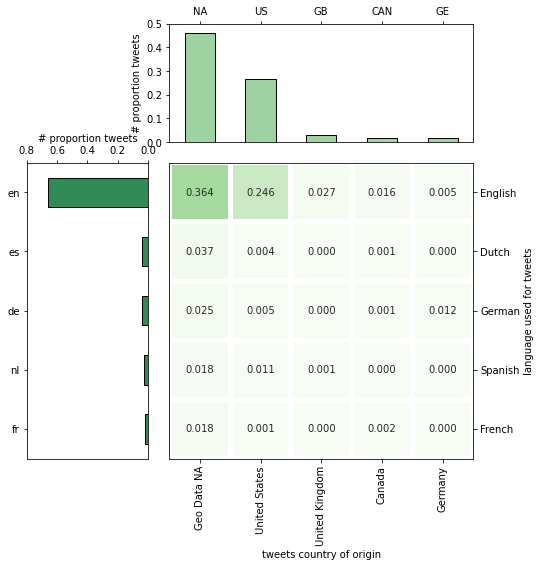

In [10]:
fig, ax=plt.subplots(2,2, figsize=(8,8), 
                     gridspec_kw={'height_ratios':[2,5], 'width_ratios':[2,5], 'wspace':0.1, 'hspace':0.1})

hide_ax = ax[0,0]
hide_axes(hide_ax)

hm_ax = ax[1,1]
draw_heatmap2(langXtab.loc[langslst,countrylst], hm_ax)
hm_ax.set_yticklabels(('English', 'Dutch', 'German','Spanish','French'), rotation=0) 
hm_ax.set_xlabel('tweets country of origin')
hm_ax.set_ylabel('language used for tweets')

bar_ax = ax[0,1]
langXtab.loc[langslst,countrylst].sum().plot.bar(ax=bar_ax, color=barcolors[1],**barstyle)
bar_ax.set_xlabel(bar_ax.get_xlabel())
bar_ax.xaxis.tick_top()
bar_ax.xaxis.set_label_position("top")
bar_ax.set_xticklabels(('NA','US', 'GB', 'CAN', 'GE', 'FRA'), rotation=0) 
bar_ax.set_ylim([0, 0.5])
bar_ax.set_xlabel('')
bar_ax.set_ylabel('# proportion tweets')

barh_ax = ax[1,0]
langXtab.loc[langslst,countrylst].sum(axis=1)[::-1].plot.barh(ax=barh_ax, color=barcolors[5],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlim([0.8, 0])
barh_ax.set_xlabel('# proportion tweets')
barh_ax.set_ylabel('')
barh_ax.set_yticklabels(langslst[::-1], rotation=0) 

plt.show()

Wanting to understand the langauges used to tweet, I used the ***```langdetect```*** function to sample 4000 tweets (which should be sufficient to provide a 99% confidence level with 1-2% margin of error for population of upto 900k tweets). The heatmap above only illustrates the top 5 languages used and the top 5 countries that they were tweeted from, in all 40 languages were detected with English accounting for almost 80% of the tweets.

In [11]:
# Identify the common UserId's in both datasets and create tables for feed visualisation
common_ids=np.intersect1d(tweets_biden.user_id, tweets_trump.user_id)
unique_b=tweets_biden[~tweets_biden.user_id.isin(common_ids)].copy()
common_b=tweets_biden[tweets_biden.user_id.isin(common_ids)].copy()
unique_t=tweets_trump[~tweets_trump.user_id.isin(common_ids)].copy()
common_t=tweets_trump[tweets_trump.user_id.isin(common_ids)].copy()

common_df=pd.concat([common_b,common_t])
common_df=common_df.drop_duplicates()

# Create columns for visualiation
unique_b['usertype'] = 'Biden'
unique_t['usertype'] = 'Trump'
common_df['usertype'] = 'Both'

# Narrow down data
cont_df=pd.concat([unique_b[['tweet','continent','usertype']].copy(),
                   unique_t[['tweet','continent','usertype']].copy(),
                   common_df[['tweet','continent','usertype']].copy()])

# Label NA Geo Data
cont_df=cont_df.fillna('Geo Data NA')

# Calculate tweet counts for each usertype and continuent
usertype=pd.DataFrame(cont_df.groupby(['usertype'])['tweet'].count().sort_values(ascending=False))
usertype=usertype.reset_index()
userlst=usertype.usertype.tolist()

continent=pd.DataFrame(cont_df.groupby(['continent'])['tweet'].count().sort_values(ascending=False)[:6])
continent=continent.reset_index()
contlst=continent.continent.to_list()

# Create crosstab to feed heatmap
contXtab=pd.crosstab(cont_df.continent, cont_df.usertype)

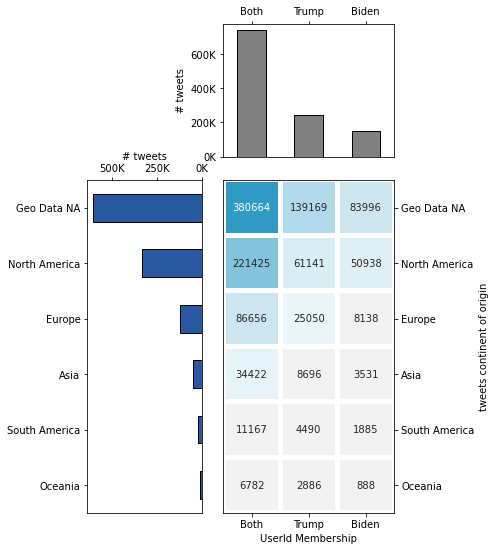

In [12]:
fig, ax=plt.subplots(2,2, figsize=(5.5,9), 
                     gridspec_kw={'height_ratios':[2,5], 'width_ratios':[2,3], 'wspace':0.15, 'hspace':0.1})

hide_ax = ax[0,0]
hide_axes(hide_ax)

hm_ax = ax[1,1]
draw_heatmap3(contXtab.loc[contlst,userlst], hm_ax)
hm_ax.set_xlabel('UserId Membership')
hm_ax.set_ylabel('tweets continent of origin')

bar_ax = ax[0,1]
contXtab.loc[contlst,userlst].sum().plot.bar(ax=bar_ax, color=barcolors[7],**barstyle)
bar_ax.set_xlabel(bar_ax.get_xlabel())
bar_ax.xaxis.tick_top()
bar_ax.xaxis.set_label_position("top")
bar_ax.yaxis.set_major_formatter(formatterK1)
bar_ax.set_ylabel('# tweets')
bar_ax.set_xlabel('')

barh_ax = ax[1,0]
contXtab.loc[contlst,userlst].sum(axis=1)[::-1].plot.barh(ax=barh_ax, color=barcolors[4],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.xaxis.set_major_formatter(formatterK1)
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlabel('# tweets')
barh_ax.set_ylabel('')

plt.show()

UserId's that post about both presidential candidates post the most, accounting for greater than 60% of the tweets. Furthermore as with the heatmaps above most tweets are from the America, at least the tweets that have geo data.

In [13]:
# Identify common tweet creation dates
common_creat=np.intersect1d(tweets_biden.created_at_r, tweets_trump.created_at_r)

# Mask out data to ensure common lenth arrays to feed visualisation
cnt_tbiden=tweets_biden[tweets_biden.created_at_r.isin(common_creat)]['created_at_r'].value_counts().sort_index()
cnt_ttrump=tweets_trump[tweets_trump.created_at_r.isin(common_creat)]['created_at_r'].value_counts().sort_index()

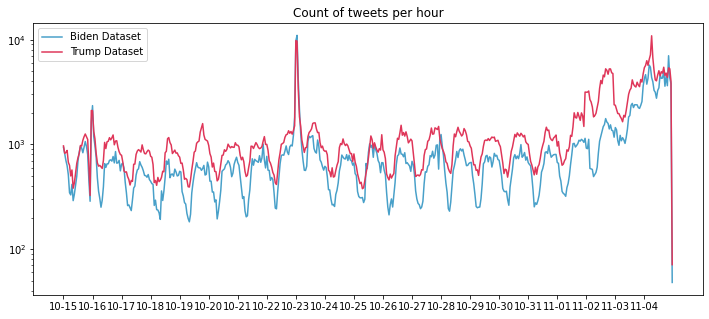

In [14]:
plt.figure(figsize=(12,5))
p6=sns.lineplot(cnt_tbiden.index, cnt_tbiden.values, color=barcolors[3], label='Biden Dataset')
p6.set_title('Count of tweets per hour')
p6=sns.lineplot(cnt_ttrump.index, cnt_ttrump.values, color=barcolors[6], label='Trump Dataset')
p6.set_xticks(range(0, len(cnt_tbiden.index), 24))
p6.set_xticklabels(common_df['created_at'].dt.strftime('%m-%d').unique().tolist())
p6.set_yscale('log')
plt.show()

#### Updated 5th Nov - Version 28
Tweets about both presidential candidates have been fairly stable in terms of tweets per hour and pattern regularity, with notable exceptions on the date of the last presidential debate and as we come up to and on the election date. On the election date itself there is large notable changes in the pattern regularity on both datasets, with an steady increasing trend in tweet volume for the both of the presidential candidates.

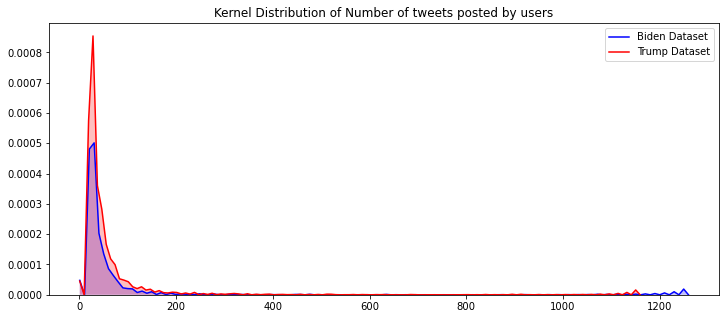

In [15]:
fig, ax=plt.subplots(1,1, figsize=(12,5))

line_ax = ax
line_ax.set_title('Kernel Distribution of Number of tweets posted by users')
sns.kdeplot(tweets_biden.groupby(['user_id'])['tweet'].count(), shade=True, color='b', label='Biden Dataset', ax=line_ax)
sns.kdeplot(tweets_trump.groupby(['user_id'])['tweet'].count(), shade=True, color='r', label='Trump Dataset', ax=line_ax)
plt.show()

The kernel distribution shows that users in both datasets have similar posting frequencies, with a small number of users in the "Biden" dataset posting more than a 1000 tweets.

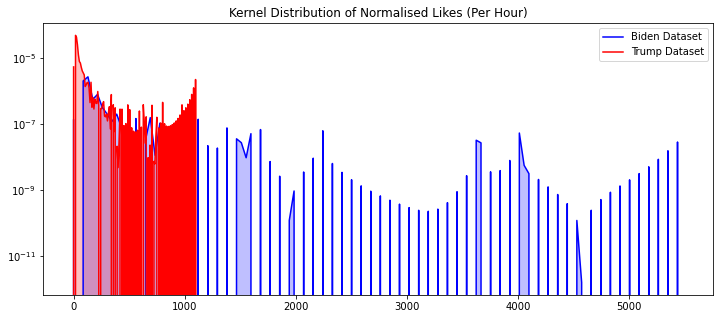

In [16]:
fig, ax=plt.subplots(1,1, figsize=(12,5))

line_ax = ax
line_ax.set_title('Kernel Distribution of Normalised Likes (Per Hour)')
sns.kdeplot(tweets_biden['likes_norm'],bw=0.1, shade=True, color='b', label='Biden Dataset', ax=line_ax)
sns.kdeplot(tweets_trump['likes_norm'],bw=0.1, shade=True, color='r', label='Trump Dataset', ax=line_ax)
line_ax.set_yscale('log')
plt.show()

The y-axis is using a log scale to extract more detail from both the tweet and retweet visualisations.

Additionally both the ***```likes```*** and ***```retweets```*** have been normalised to ***```likes```*** and ***```retweets```*** per hour to try to account for the difference in time from the creation of each tweet and the time of collecting the data. 

The "Biden" dataset shows small but persistant number of tweets with higher normalised "Likes" than in the "Trump" dataset.

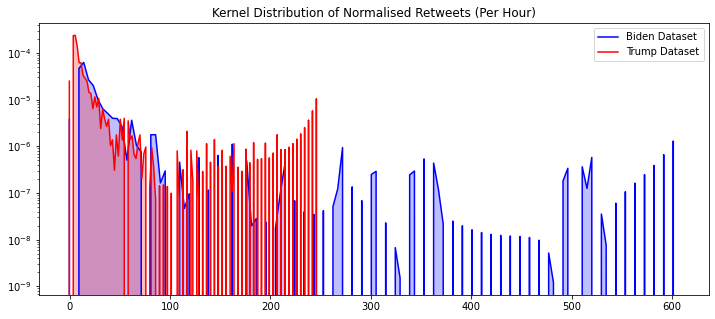

In [17]:
fig, ax=plt.subplots(1,1, figsize=(12,5))

line_ax = ax
line_ax.set_title('Kernel Distribution of Normalised Retweets (Per Hour)')
sns.kdeplot(tweets_biden['retweet_norm'],bw=0.1, shade=True, color='b', label='Biden Dataset', ax=line_ax)
sns.kdeplot(tweets_trump['retweet_norm'],bw=0.1, shade=True, color='r', label='Trump Dataset', ax=line_ax)
line_ax.set_yscale('log')
plt.show()

The "Biden" dataset, similar to the previous visualisation, shows small but persistant number of tweets with higher normalised "retweets" than seen in the "Trump" dataset..

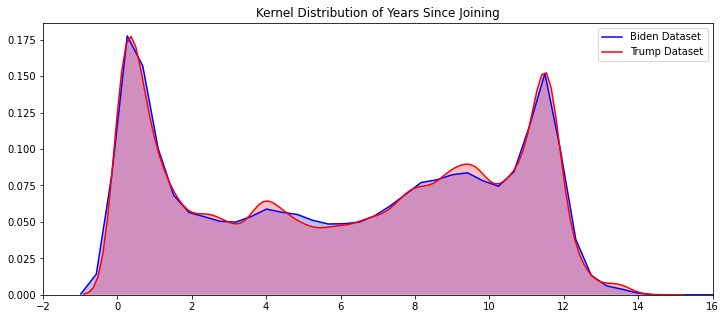

In [18]:
fig, ax=plt.subplots(1,1, figsize=(12,5))
tweets_biden['user_join_length'] = max(tweets_biden['created_at']) - tweets_biden['user_join_date']
tweets_trump['user_join_length'] = max(tweets_trump['created_at']) - tweets_trump['user_join_date']

line_ax = ax
plt.xlim(-2, 16)
line_ax.set_title('Kernel Distribution of Years Since Joining')
sns.kdeplot(tweets_biden['user_join_length'].dt.days/365.25, shade=True, color='b', label='Biden Dataset', ax=line_ax)
sns.kdeplot(tweets_trump['user_join_length'].dt.days/365.25, shade=True, color='r', label='Trump Dataset', ax=line_ax)
plt.show()

In terms of years since joiner for users, both dataset have a similar distribution with a peak at 12 years and another peak showing users joining twitter to tweet about each of the respective presidential candidates.

## Chapter 2: N-grams and Sentiment Analysis (VADAR)

In second and last part of this kernel I will perform Sentiment Analysis on each of the datasets respectively to ascertain the overall sentiment. To perform the Sentiment Analysis I will be using VADER (Valence Aware Dictionary and sEntiment Reasoner) package, which is a lexicon and rule-based sentiment analysis tool that is specifically tuned to sentiments expressed in social media! Perfect for my use case.

In [19]:
# Obtain tweets only from data that has Geo Data from the US
text1=tweets_biden.loc[tweets_biden['country'] == 'United States of America']['tweet']
text2=tweets_trump.loc[tweets_trump['country'] == 'United States of America']['tweet']

Before the N-gram analysis we first must clean the tweets to remove stopwords, strings with "http" etc and then lemmatize the words.

In [20]:
def clean1(sent):
    filtered_sent=""
    stopwords = nltk.corpus.stopwords.words('english')
    sent = (unicodedata.normalize('NFKD', sent)
            .encode('ascii', 'ignore')
            .decode('utf-8', 'ignore')
            .lower())
    sent = re.sub(r'#.+|https.+|[^(a-zA-Z)\s]','',sent)
    words=sent.split()
    for word in words:
        if word not in stopwords:
            filtered_sent=filtered_sent+' '+word
    return filtered_sent

def clean2(text):
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    text = (unicodedata.normalize('NFKD', text)
            .encode('ascii', 'ignore')
            .decode('utf-8', 'ignore')
            .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

words1 = clean2(''.join(str(text1.apply(clean1).tolist())))
words2 = clean2(''.join(str(text2.apply(clean1).tolist())))
words1[:10]

['islandgirlprv',
 'bradbeauregardj',
 'meidastouch',
 'ccp',
 'thats',
 'always',
 'fine',
 'jack',
 'vijaya',
 'dickc']

In [21]:
# Obtain top 10 Bi and Tri Ngrams from cleaned data
biden_2ngrams=(pd.Series(nltk.ngrams(words1, 2)).value_counts())[:10]
trump_2ngrams=(pd.Series(nltk.ngrams(words2, 2)).value_counts())[:10]
biden_3ngrams=(pd.Series(nltk.ngrams(words1, 3)).value_counts())[:10]
trump_3ngrams=(pd.Series(nltk.ngrams(words2, 3)).value_counts())[:10]

# Input Bi and Tri Ngrams into dataframes for plotting
biden_ngrams=pd.concat([biden_2ngrams,biden_3ngrams])
trump_ngrams=pd.concat([trump_2ngrams,trump_3ngrams])

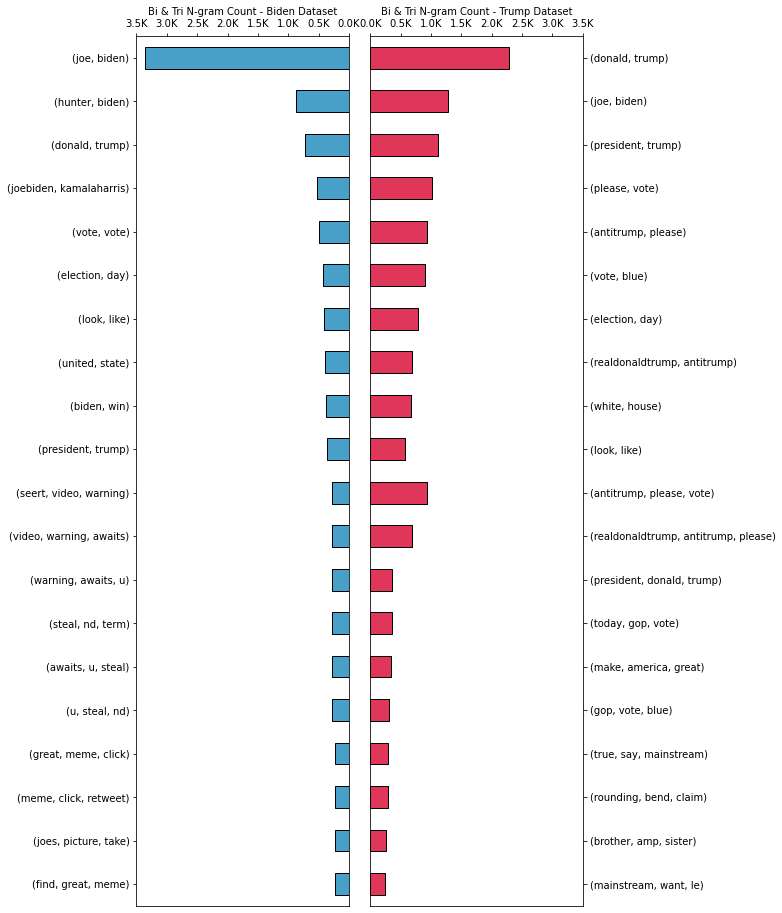

In [22]:
fig, ax=plt.subplots(1,2, figsize=(8,16), 
                     gridspec_kw={'width_ratios':[1,1], 'wspace':0.1, 'hspace':0.1})

barh_ax = ax[0]
biden_ngrams[::-1].plot.barh(ax=barh_ax, color=barcolors[3],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.xaxis.set_major_formatter(formatterK2)
barh_ax.set_xlim([0, 3500])
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlabel('Bi & Tri N-gram Count - Biden Dataset')
barh_ax.set_ylabel('')

barh_ax = ax[1]
trump_ngrams[::-1].plot.barh(ax=barh_ax, color=barcolors[6],**barstyle)
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.xaxis.set_major_formatter(formatterK2)
barh_ax.set_xlim([0, 3500])
barh_ax.set_xlim(barh_ax.get_xlim())
barh_ax.yaxis.tick_right()
barh_ax.set_xlabel('Bi & Tri N-gram Count - Trump Dataset')
barh_ax.set_ylabel('')
plt.show()

The above bar chart shows the most common Bi and Tri N-gram's in each of the respective datasets, filtered from words just from the "United States of America". The N-gram's show a clear relation to the upcoming election and each respective dataset seems to be related to each of the presidential candidates.

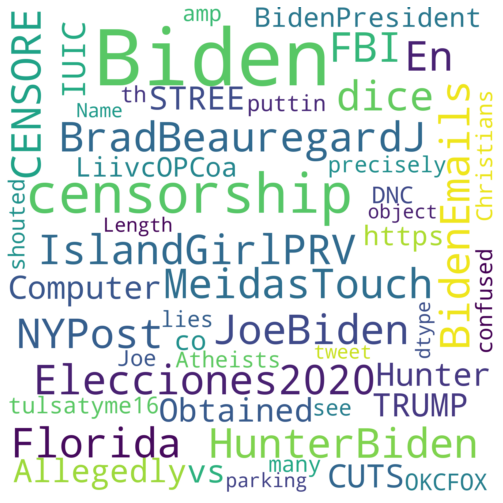

In [23]:
plt.subplots(1,1, figsize=(9,9))
wc_b = WordCloud(stopwords=STOPWORDS, 
                 background_color="white", max_words=2000,
                 max_font_size=256, random_state=42,
                 width=1600, height=1600)
wc_b.generate(str(text1.dropna()))
plt.imshow(wc_b, interpolation="bilinear")
plt.axis('off')
plt.show()

Wordcloud created just from the "Biden" dataset, if I am honest I cannot gain much information from this.

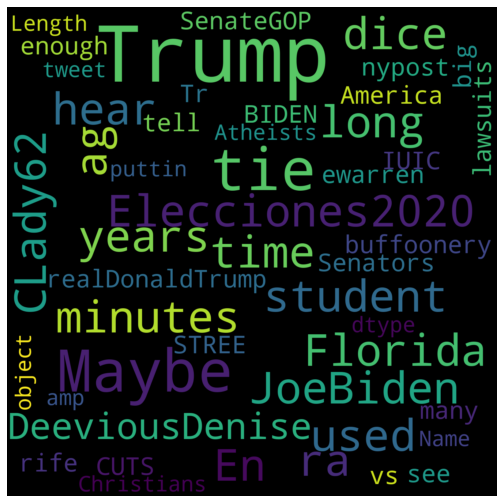

In [24]:
plt.subplots(1,1, figsize=(9,9))
wc_t = WordCloud(stopwords=STOPWORDS, 
                 background_color="black", max_words=2000,
                 max_font_size=256, random_state=42,
                 width=1600, height=1600)
wc_t.generate(str(text2.dropna()))
plt.imshow(wc_t, interpolation="bilinear")
plt.axis('off')
plt.show()

Wordcloud created just from the "Trump" dataset, similarly to the above wordcloud I cannot ascertain much information from this.

In [25]:
# Obtain sentiment scores for both datasets
sid = SentimentIntensityAnalyzer()
tweets_biden['VADAR']=sentiment(tweets_biden['tweet'])
tweets_trump['VADAR']=sentiment(tweets_trump['tweet'])
tweets_biden['compound']  = tweets_biden['VADAR'].apply(lambda score_dict: score_dict['compound'])
tweets_trump['compound']  = tweets_trump['VADAR'].apply(lambda score_dict: score_dict['compound'])
tweets_trump['sentiment']  = tweets_trump['compound'].apply(lambda x: 'pos' if x > 0.05 else ('neg' if x < -0.05 else 'neu'))
tweets_biden['sentiment']  = tweets_biden['compound'].apply(lambda x: 'pos' if x > 0.05 else ('neg' if x < -0.05 else 'neu'))

# Create 52 state set
states=set(tweets_biden.loc[tweets_biden['country'] == 'United States of America']['state'].dropna())
states.remove('District of Columbia')
states.remove('Northern Mariana Islands')

# Create feature to allow masking of data and then mask data for votable states
tweets_biden['voting_rights']=tweets_biden['state'].apply(lambda x: 'Yes' if x in states else 'No')
tweets_trump['voting_rights']=tweets_trump['state'].apply(lambda x: 'Yes' if x in states else 'No')
sent_t=tweets_trump.loc[tweets_trump['voting_rights'] == 'Yes']
sent_b=tweets_biden.loc[tweets_biden['voting_rights'] == 'Yes']

# Further mask data for only the last 14 days
state_b=sent_b.loc[sent_b['created_at'] > max(sent_b['created_at']) - timedelta(14)]
state_t=sent_t.loc[sent_t['created_at'] > max(sent_t['created_at']) - timedelta(14)]
state_b_mean=state_b.groupby('state')['compound'].mean().reset_index()
state_t_mean=state_t.groupby('state')['compound'].mean().reset_index()

# Further mask data for only the last 14 days
state_bp=sent_b.loc[sent_b['created_at'] < min(sent_b['created_at']) + timedelta(14)]
state_tp=sent_t.loc[sent_t['created_at'] < min(sent_t['created_at']) + timedelta(14)]
state_bp_mean=state_bp.groupby('state')['compound'].mean().reset_index()
state_tp_mean=state_tp.groupby('state')['compound'].mean().reset_index()

# Create dataframe for visualisation
states_sent=pd.DataFrame({'state':state_b_mean['state'],
                          'biden1':state_b_mean['compound'],
                          'trump1':state_t_mean['compound'],
                          'biden2':state_bp_mean['compound'],
                          'trump2':state_tp_mean['compound'],})

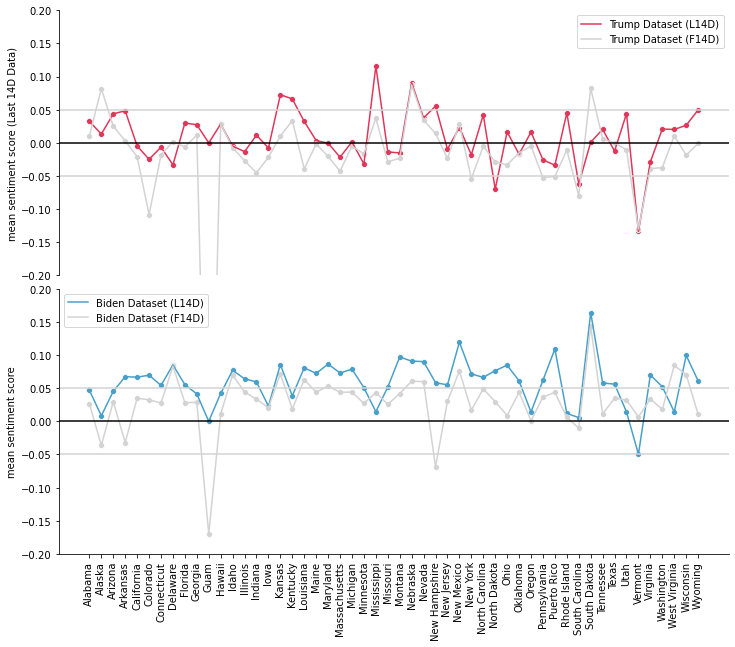

In [26]:
fig, ax=plt.subplots(2,1, figsize=(12,10), gridspec_kw={'hspace':0.05})
lineax=ax[0]
sns.lineplot(x='state', y='trump1', color=barcolors[6], data=states_sent, ax=lineax, label='Trump Dataset (L14D)')
sns.scatterplot(x='state', y='trump1', color=barcolors[6], data=states_sent, ax=lineax)
sns.lineplot(x='state', y='trump2', color='lightgrey', data=states_sent, ax=lineax, label='Trump Dataset (F14D)')
sns.scatterplot(x='state', y='trump2', color='lightgrey', data=states_sent, ax=lineax)
lineax.set_ylim([-0.2, 0.2])
lineax.set_ylabel('mean sentiment score (Last 14D Data)')
lineax.set_xlabel('')
plt.xticks(rotation=90)
lineax.axhline(y=0, color='k', linestyle='-')
lineax.axhline(y=0.05, color='lightgrey', linestyle='-')
lineax.axhline(y=-0.05, color='lightgrey', linestyle='-')
lineax.axes.get_xaxis().set_ticks([])
lineax.spines['right'].set_visible(False)
lineax.spines['top'].set_visible(False)
lineax.spines['bottom'].set_visible(False)

lineax=ax[1]
sns.lineplot(x='state', y='biden1', color=barcolors[3], data=states_sent, ax=lineax, label='Biden Dataset (L14D)')
sns.scatterplot(x='state', y='biden1', color=barcolors[3], data=states_sent, ax=lineax)
sns.lineplot(x='state', y='biden2', color='lightgrey', data=states_sent, ax=lineax, label='Biden Dataset (F14D)')
sns.scatterplot(x='state', y='biden2', color='lightgrey', data=states_sent, ax=lineax)
lineax.set_ylim([-0.2, 0.2])
lineax.set_ylabel('mean sentiment score')
lineax.set_xlabel('')
plt.xticks(rotation=90)
lineax.axhline(y=0, color='k', linestyle='-')
lineax.axhline(y=0.05, color='lightgrey', linestyle='-')
lineax.axhline(y=-0.05, color='lightgrey', linestyle='-')
lineax.spines['right'].set_visible(False)
lineax.spines['top'].set_visible(False)
plt.show()

#### Updated 4th Nov - Version 26
The VADAR analysis produces a compound sentiment score, to create the visualisation I took the mean compound score for the most recent 14 days (Labelled L14D on the charts) and the first 14 days (Labelled F14D and light grey on the charts ) for each state.

It should be noted that any sentiment score between 0.05 and -0.05 is considered "Neutral".

The results seems to show a large number of states are trending to a “Positive”  sentiment score for the democratic candidate from the previous more “Neutral” sentiment. Whereas most states are still largely "Neutral" for the republican candidate.

In [27]:
# Calculate counts of sentiments
stack_t=sent_t.groupby(['created_at_r','sentiment'])['tweet'].count().reset_index()
stack_b=sent_b.groupby(['created_at_r','sentiment'])['tweet'].count().reset_index()

# Setup np.arrays to allow quick calculations of the proportions of tweet sentiments
a1=np.array(stack_b.loc[stack_b.sentiment == 'pos']['tweet'].tolist())
b1=np.array(stack_b.loc[stack_b.sentiment == 'neu']['tweet'].tolist())
c1=np.array(stack_b.loc[stack_b.sentiment == 'neg']['tweet'].tolist())
d1=np.array(stack_b.groupby('created_at_r')['tweet'].sum().tolist())

a2=np.array(stack_t.loc[stack_t.sentiment == 'pos']['tweet'].tolist())
b2=np.array(stack_t.loc[stack_t.sentiment == 'neu']['tweet'].tolist())
c2=np.array(stack_t.loc[stack_t.sentiment == 'neg']['tweet'].tolist())
d2=np.array(stack_t.groupby('created_at_r')['tweet'].sum().tolist())

# Calculate sentiment proportions and feed into dataframes for visualisation
SentiDat_b=pd.DataFrame({'date':pd.to_datetime(stack_b.created_at_r.unique()),
                         'datenum':dates.datestr2num(stack_b.created_at_r.unique()),
                         'pos':a1/d1,'neu':b1/d1,'neg':c1/d1})

SentiDat_t=pd.DataFrame({'date':pd.to_datetime(stack_t.created_at_r.unique()),
                         'datenum':dates.datestr2num(stack_t.created_at_r.unique()),
                         'pos':a2/d2,'neu':b2/d2,'neg':c2/d2})

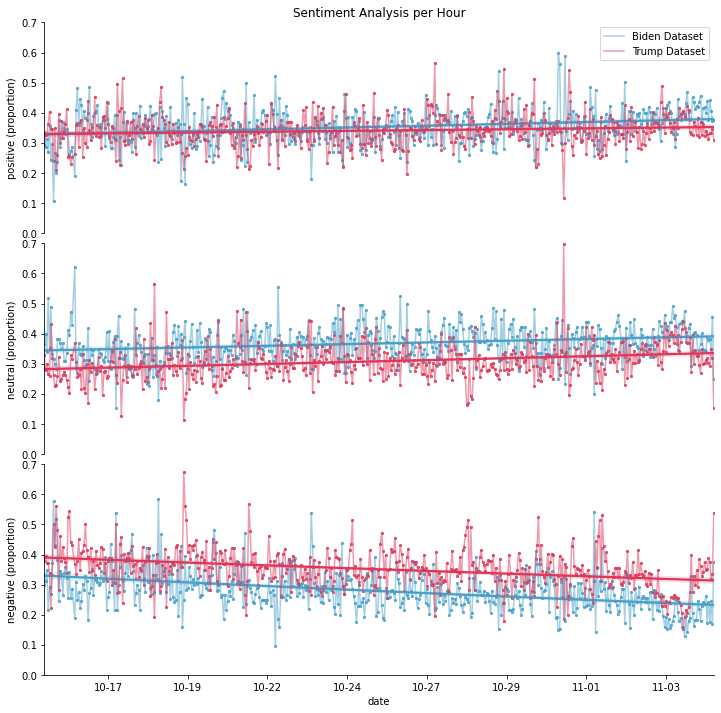

In [28]:
@plt.FuncFormatter
def fake_dates(x, pos):
    """ Custom formater to turn floats into e.g., 05-08"""
    return dates.num2date(x).strftime('%m-%d')

fig, ax=plt.subplots(3,1, figsize=(12,12), gridspec_kw={'hspace':0.05})
 
# Plot
lineax=ax[0]
lineax.set_title('Sentiment Analysis per Hour')
sns.regplot(x='datenum',y='pos', data=SentiDat_b, ax=lineax, color=barcolors[3], scatter_kws={'s':5}, logistic=True, ci=95)
sns.lineplot(x='datenum',y='pos', data=SentiDat_b, ax=lineax, color=barcolors[3], alpha=0.5, label='Biden Dataset')
sns.regplot(x='datenum',y='pos', data=SentiDat_t, ax=lineax, color=barcolors[6], scatter_kws={'s':5}, logistic=True, ci=95)
sns.lineplot(x='datenum',y='pos', data=SentiDat_t, ax=lineax, color=barcolors[6], alpha=0.5, label='Trump Dataset')
lineax.xaxis.set_major_formatter(fake_dates)
lineax.set_ylim([0, 0.7])
lineax.set_xlabel('')
lineax.set_ylabel('positive (proportion)')
lineax.axes.get_xaxis().set_ticks([])
lineax.spines['right'].set_visible(False)
lineax.spines['top'].set_visible(False)
lineax.spines['bottom'].set_visible(False)

lineax1=ax[1]
sns.regplot(x='datenum',y='neu', data=SentiDat_b, ax=lineax1, color=barcolors[3], scatter_kws={'s':5}, logistic=True, ci=95)
sns.lineplot(x='datenum',y='neu', data=SentiDat_b, ax=lineax1, color=barcolors[3], alpha=0.5)
sns.regplot(x='datenum',y='neu', data=SentiDat_t, ax=lineax1, color=barcolors[6], scatter_kws={'s':5}, logistic=True, ci=95)
sns.lineplot(x='datenum',y='neu', data=SentiDat_t, ax=lineax1, color=barcolors[6], alpha=0.5)
lineax1.xaxis.set_major_formatter(fake_dates)
lineax1.set_ylim([0, 0.7])
lineax1.set_xlabel('')
lineax1.set_ylabel('neutral (proportion)')
lineax1.axes.get_xaxis().set_ticks([])
lineax1.spines['right'].set_visible(False)
lineax1.spines['top'].set_visible(False)
lineax1.spines['bottom'].set_visible(False)

lineax2=ax[2]
sns.regplot(x='datenum',y='neg', data=SentiDat_b, ax=lineax2, color=barcolors[3], scatter_kws={'s':5}, logistic=True, ci=95)
sns.lineplot(x='datenum',y='neg', data=SentiDat_b, ax=lineax2, color=barcolors[3], alpha=0.5)
sns.regplot(x='datenum',y='neg', data=SentiDat_t, ax=lineax2, color=barcolors[6], scatter_kws={'s':5}, logistic=True, ci=95)
sns.lineplot(x='datenum',y='neg', data=SentiDat_t, ax=lineax2, color=barcolors[6], alpha=0.5)
lineax2.xaxis.set_major_formatter(fake_dates)
lineax2.set_ylim([0, 0.7])
lineax2.set_ylabel('negative (proportion)')
lineax2.set_xlabel('date')
lineax2.spines['right'].set_visible(False)
lineax2.spines['top'].set_visible(False)

plt.show()

#### Updated 5th Nov - Version 28
The above visualisation was generated by first assigning each tweet a "Positive", "Neutral" or "Negative" sentiment then summing those for each day and calculating the proportions for each sentiment group. Then using logistic regression to find the best fit line to better show the sentiment trend overtime. When viewing the results:

The trend over the entire timeframe of the dataset for both presidential candidates is an increasing "Positive" and "Neutral" sentiment, with reducing negative sentiment. 

However interesting developments occured as we approached and subsequent to election day, where we see "Positive" sentiment increase quicker for the democratic candidate over the republican where we see a noticeable gap develop in the logistic regression lines. 

Moving onto the "Neutral" sentiment, the differences between two candidates remain largely steady until there is a noticable blip on election day where the gap briefly disappears before then returning to the previous steady difference.

Post-election day we see a shape increase in "Negative" sentiment for the republican candidate. 

## Conclusion

#### Updated 5th Nov - Version 28
In this kernel, we performed EDA and sentiment analysis on the [US Election 2020 Tweets dataset](https://www.kaggle.com/manchunhui/us-election-2020-tweets). 

There is interest in the US elections from many different countries in the world with tweets from 40 different languages, however with a large proportion of the tweets in English and originating from the US.

The sentiment analysis was performed only on data that had geo-data originating from the "United States of America" to try to ascertain the sentiment in each respective dataset and therefore each presidential candidate. When reviewing sentiment at the state level as we approached the election date a large number of states were trending to a “Positive” sentiment score for the democratic candidate from the previously more “Neutral” sentiment. Whereas most states are still largely “Neutral” for the republican candidate. This trend is correlatable when viewing the sentiment analysis from a date perspective. 

I hope you enjoyed reading this kernel, please do not hesitate to comment below if you have any feedback!